<a href="https://colab.research.google.com/github/HyungunKim/IMLAB_SelfDrivingCarla/blob/main/experiments/FKM_video_JH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/class_home/SF2021/Forward\ Kinematics\ Model

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1QnAn1UfhSxAGeRHXouSfr-_KmpnWU4dt/class_home/SF2021/Forward Kinematics Model


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import os 
import csv
import shutil
import matplotlib.pyplot as plt
# Enable interactive plot
%matplotlib notebook


In [58]:
file_name = f'./vlog_v2/vlog_1.csv'
df = pd.read_csv(file_name)
min_x = df['x'].min()
min_y = df['y'].min()
min_yaw = df['yaw'].min()
min_vx = df['vx'].min()
min_vy = df['vy'].min()
min_spds = math.sqrt(min_vx**2 + min_vy**2)

max_x = df['x'].max()
max_y = df['y'].max()
max_yaw = df['yaw'].max()
max_vx = df['vx'].max()
max_vy = df['vy'].max()
max_spds = math.sqrt(max_vx**2 + max_vy**2)


In [ ]:
# REAR_WB = 2.3934898 - 0.3
# FRONT_WB = 2.8905065
# THROT_ACCEL = 0.93875474
# BRAKE_ACCEL = 5.158656
# STEER_GAIN = 0.5236

In [77]:
REAR_WB = 1.8480084
FRONT_WB = 1.2657973
THROT_ACCEL = 0.7607523
BRAKE_ACCEL = 1.1647251
STEER_GAIN = 0.73196226

In [78]:
def make_train_data(file_name):
    df = pd.read_csv(file_name)
    time_index = np.round(df['t'],2)
    df['yaw'] = df['yaw'] * 3.14159265359/180   # 180 -> radian

    npvx = df['vx'].values                      # calculate val
    npvy = df['vy'].values
    npspds = np.sqrt(npvx**2 + npvy**2)
    df.pop('z')
    df.pop('vz')
    df.pop('roll')
    df.pop('pitch')
    df.pop('reverse')
    df['spds'] = npspds
    X_df = df.copy()
    
    x_df_locs = X_df[['x', 'y']]
    x_df_yaws = X_df[['yaw']]
    x_df_spds = X_df[['vx', 'vy']]
    x_df_acts = X_df[['steer','throttle','brake']]

    xlocs = x_df_locs.values
    xyaws = x_df_yaws.values
    xspds = x_df_spds.values
    xacts = x_df_acts.values

    sp = np.zeros(len(xspds))
    for i in range(len(xspds)):
        sp[i] = math.sqrt(xspds[i][0]**2 + xspds[i][1]**2)

    

    X = np.hstack([xlocs, xyaws, sp.reshape(len(sp), 1), xacts])

    return X, time_index

In [79]:
def TimeTest(X, Act_np, time):
    dt = 0.1 # time step
    idx = int(time*10)

    X_locs = X[:2]
    X_yaws = X[2:3]
    X_spds = X[3:4]
    #X_acts = Act_np[4:][idx]
    X_acts = Act_np[idx][ 4:]
    steer = X_acts[0:1]
    throt = X_acts[1:2]
    brake = X_acts[2:3] #.byte()

    if (brake == 0):
        accel = THROT_ACCEL*throt
    else:
        accel = -BRAKE_ACCEL

    wheel = STEER_GAIN * steer
    beta = np.arctan(REAR_WB * np.tan(wheel)/(FRONT_WB + REAR_WB)) #라디안 값
        
    next_locs = X_locs + (X_spds * (np.concatenate([np.cos(X_yaws+beta), np.sin(X_yaws+beta)], -1) * dt))
    # next_yaws = yaws + divide(spds* sin(beta) * self.dt, self.rear_wb  + 0.001) # rad
    next_yaws = X_yaws + (X_spds * (np.sin(beta) * dt))/(REAR_WB + 0.001)
    next_spds = X_spds + accel * dt
    # y = next_locs, next_yaws, next_speeds

    
    return np.concatenate([next_locs, next_yaws, np.maximum(np.zeros_like(next_spds), next_spds)], -1)

    

In [80]:
TimeTest(np.array([0,0,0,1]), np.array([[0,0,0,1,1,0,1]]), 0)

array([0.08823929, 0.04705134, 0.0254468 , 0.88352749])

In [81]:
states = np.zeros((100, 4))
state = np.array([0,0,0,1])
control = np.array([[0,0,0,1,1,0,0]]) 

for i in range(100):
    states[i] = TimeTest(state, control, 0)
    state = states[i]

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


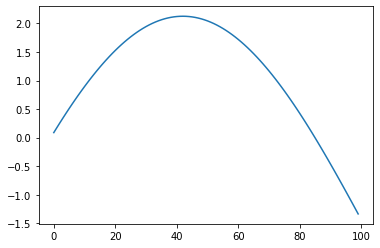

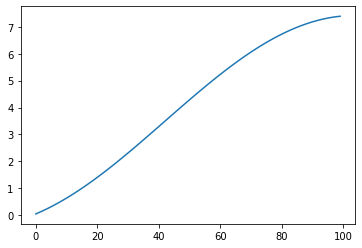

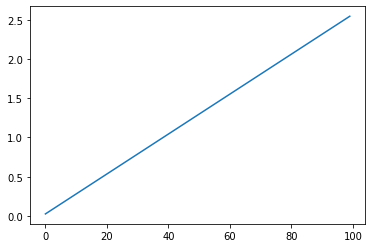

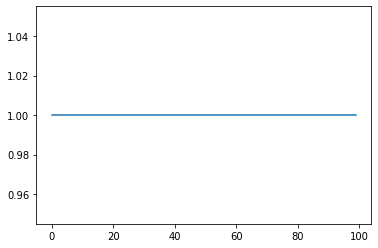

In [82]:
%matplotlib inline
plt.plot(states[:,0])
plt.show()

plt.plot(states[:,1])
plt.show()

plt.plot(states[:,2])
plt.show()

plt.plot(states[:,3])
plt.show()

In [83]:
df.columns
df['brake']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9995    1.0
9996    1.0
9997    1.0
9998    1.0
9999    1.0
Name: brake, Length: 10000, dtype: float64

In [84]:
for i in X_data_list[0][:,4]:
  print(i)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
0.000725481309928
0.0007956703193485737
0.0006308898446150124
0.0005659989546984434
0.0005049749743193388
0.00045699754264205694
0.00041145773138850933
0.0003655543259810656
0.00031767826294526463
0.0003543785132933408
0.000261135573964566
0.0002190284722018987
0.00019181816605851051
0.00016305416647810492
0.00013577657227870077
0.00010944920359179378
8.872157195582986e-05
0.00010059594933409244
6.257873610593379e-05
4.524201358435676e-05
3.296965587651357e-05
2.510636841179803e-05
1.87318328244146e-05
1.1581243597902358e-05
1.4681934771942904e-05
1.1702359188348055e-05
8.066594091360457e-06
1.533836075395811e-05
1.772254654497374e-05
7.350981832132675e-06
-1.054168023983948e-06
-1.4526545783155598e-05
-2.722507815633435e-05
-3.807693792623468e-05
-5.9837937442353e-05
-7.844156061764807e-05
-9.865635365713388e-05
-0.00012566828809212893
-0.00014380126958712938
-0.0001683142763795331
-0.00019098192569799719
-0.00022110283316578721
-0.00025563751114532

In [88]:
future = 5 * 10
# test_time5 = np.zeros((5,10000-future,future,4))  # file_number, time_index, time_step, feature
X_data_list = []

for i in range(1,6,1):
    file_name = f'./vlog_v2/vlog_{i}.csv'
    x, time_index = make_train_data(file_name)
    X_data_list.append(x)
    # print(x.shape)
    for j in range(len(time_index)-future):
        time = time_index[j]
        
        next_x = x[j]
        next_x = next_x[:4]
        for k in range(future):
#             print(next_x, end=" ")
            for p in range(4):
                test_time5[i-1][j][k][p] = next_x[p]  
            next_x = TimeTest(next_x, x, time)
            # print(next_x)              
        
    print(test_time5.shape)
    
    

(5, 9950, 50, 4)
(5, 9950, 50, 4)
(5, 9950, 50, 4)
(5, 9950, 50, 4)
(5, 9950, 50, 4)


0


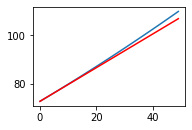

1


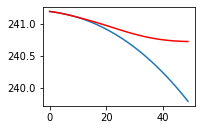

2


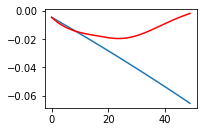

3


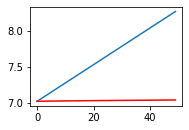

0


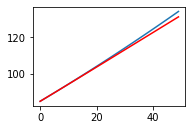

1


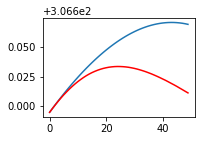

2


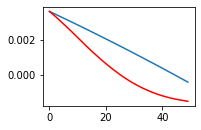

3


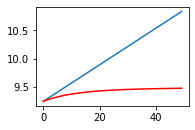

In [90]:
def show_subplot(test_time, X_data_list,i,k):
    for j in range(4):
        print(j)
        t1 = np.arange(0,50,1)
        t2 = np.arange(0,50,1)
        plt.subplot(2,2,j+1)
        plt.plot(t1, test_time[k][i][:,j], t2, X_data_list[k][i:(i+50)][:,:4][:,j], 'r-')
        plt.show()
i = 830
k = 1
show_subplot(test_time5 ,X_data_list, i, k)
plt.show()

i = 830
k = 0
show_subplot(test_time5 ,X_data_list, i, k)
plt.show()


In [ ]:
future = 10 * 20
test_time10 = np.zeros((5,9800,future,4))  # file_number, time_index, time_step, feature
X_data_list = []
for i in range(1,6,1):
    file_name = f'vlog_{i}.csv'
    x, time_index = make_train_data(file_name)
    X_data_list.append(x)
    for j in range(len(time_index)-200):
        time = time_index[j]
        next_x = x[j]
        next_x = next_x[:4]
        for k in range(future):
#             print(next_x, end=" ")
            for p in range(4):
                test_time10[i-1][j][k][p] = next_x[p]  
            next_x = TimeTest(next_x, x, time)
#             print(next_x)              
        
    print(test_time10.shape)

(5, 9800, 200, 4)
(5, 9800, 200, 4)
(5, 9800, 200, 4)
(5, 9800, 200, 4)
(5, 9800, 200, 4)


In [ ]:
future = 15 * 20
test_time15 = np.zeros((5,9700,future,4))  # file_number, time_index, time_step, feature
X_data_list = []
for i in range(1,6,1):
    file_name = f'vlog_{i}.csv'
    x, time_index = make_train_data(file_name)
    X_data_list.append(x)
    for j in range(len(time_index)-300):
        time = time_index[j]
        next_x = x[j]
        next_x = next_x[:4]
        for k in range(future):
#             print(next_x, end=" ")
            for p in range(4):
                test_time15[i-1][j][k][p] = next_x[p]  
            next_x = TimeTest(next_x, x, time)
#             print(next_x)              
        
    print(test_time15.shape)

(5, 9700, 300, 4)


KeyboardInterrupt: ignored

In [ ]:
print(test_time[1][30])

In [91]:
testtime0 = test_time5[0,:,:,0]
Ytime0 = np.squeeze(X_data_list[0][:,:1])
testtime1 = test_time5[0,:,:,1]
Ytime1 = np.squeeze(X_data_list[0][:,1:2])
testtime2 = test_time5[0,:,:,2]
Ytime2 = np.squeeze(X_data_list[0][:,2:3])
testtime3 = test_time5[0,:,:,3]
Ytime3 = np.squeeze(X_data_list[0][:,3:4])


In [92]:
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np
import random
import time

%matplotlib notebook
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(2,2)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
# fig, ax1 = plt.plot()

ax1.set_xlim(0, 50)
ax1.set_ylim(min_x, max_x)

ax2.set_xlim(0, 50)
ax2.set_ylim(min_y, max_y+20)

ax3.set_xlim(0, 50)
ax3.set_ylim(-4, 4)

ax4.set_xlim(0, 50)
ax4.set_ylim(0, 10)

ax1.title.set_text('X')
ax1.set_xticks([])
ax2.title.set_text('Y')
ax2.set_xticks([])
ax3.title.set_text('yaw')
ax4.title.set_text('speeds')

x = np.arange(0,50)
line1, = ax1.plot([], [], color = 'r')
line2, = ax1.plot([], [], lw=0.5, color='b')
line3, = ax2.plot([], [], color = 'r')
line4, = ax2.plot([], [], lw=0.5, color='b')
line5, = ax3.plot([], [], color = 'r')
line6, = ax3.plot([], [], lw=0.5, color='b')
line7, = ax4.plot([], [], color = 'r')
line8, = ax4.plot([], [], lw=0.5, color='b')

line = [line1, line2, line3, line4, line5, line6, line7, line8]

def init():
    return line

x = np.linspace(0,5,101)
# print(x)
def animate1(i):
    x = np.arange(0,50)
    y = testtime0[i,:]
    y2 = Ytime0[i:i+50]
    y3 = testtime1[i,:]
    y4 = Ytime1[i:i+50]
    y5 = testtime2[i,:]
    y6 = Ytime2[i:i+50]
    y7 = testtime3[i,:]
    y8 = Ytime3[i:i+50]
    
    line[0].set_data(x,y)
    line[1].set_data(x,y2)
    line[2].set_data(x,y3)
    line[3].set_data(x,y4)
    line[4].set_data(x,y5)
    line[5].set_data(x,y6)
    line[6].set_data(x,y7)
    line[7].set_data(x,y8)
    return line


anim = animation.FuncAnimation(fig, animate1, init_func= init ,frames=9900, interval=1, blit=False, repeat=False)
#anim.save(r'animation_5.gif', fps=200)

<IPython.core.display.Javascript object>

In [93]:
HTML_VIDEO = anim.to_html5_video()

In [94]:
from IPython.core.display import display, HTML
display(HTML(HTML_VIDEO))

In [65]:
from IPython.core.display import display, HTML
display(HTML(HTML_VIDEO))

In [ ]:
from IPython.core.display import display, HTML
display(HTML(HTML_VIDEO))

In [ ]:
testtime10x = test_time10[1,:,:,0]
Ytime10y = np.squeeze(X_data_list[1][:,:1])
testtime10y = test_time10[1,:,:,1]
Ytime10y = np.squeeze(X_data_list[1][:,1:2])
testtime10yaw = test_time10[1,:,:,2]
Ytime10yaw = np.squeeze(X_data_list[1][:,2:3])
testtime10spds = test_time10[1,:,:,3]
Ytime10spds = np.squeeze(X_data_list[1][:,3:4])


<IPython.core.display.Javascript object>


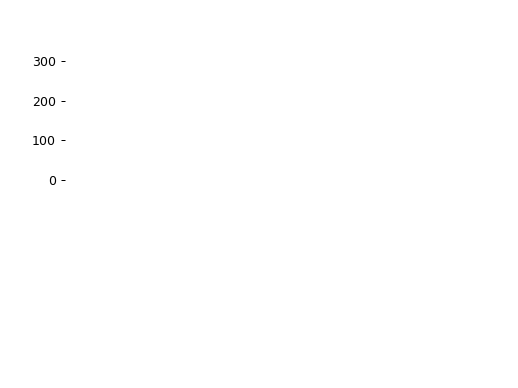

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np
import random
import time
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(2,2)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
# fig, ax1 = plt.plot()

ax1.set_xlim(0, 200)
ax1.set_ylim(min_x, max_x)

ax2.set_xlim(0, 200)
ax2.set_ylim(min_y, max_y+20)

ax3.set_xlim(0, 200)
ax3.set_ylim(min_yaw, max_yaw)

ax4.set_xlim(0, 200)
ax4.set_ylim(0, 10)

ax1.title.set_text('X')
ax1.set_xticks([])
ax2.title.set_text('Y')
ax2.set_xticks([])
ax3.title.set_text('yaw')
ax4.title.set_text('speeds')

x = np.arange(0,200)
line1, = ax1.plot([], [], color = 'r')
line2, = ax1.plot([], [], lw=0.5, color='b')
line3, = ax2.plot([], [], color = 'r')
line4, = ax2.plot([], [], lw=0.5, color='b')
line5, = ax3.plot([], [], color = 'r')
line6, = ax3.plot([], [], lw=0.5, color='b')
line7, = ax4.plot([], [], color = 'r')
line8, = ax4.plot([], [], lw=0.5, color='b')

line = [line1, line2, line3, line4, line5, line6, line7, line8]

def init():
    return line


def animate1(i):
    x = np.arange(0,200)
    y = testtime10x[i,:]
    y2 = Ytime10x[i:i+200]
    y3 = testtime10y[i,:]
    y4 = Ytime10y[i:i+200]
    y5 = testtime10yaw[i,:]
    y6 = Ytime10yaw[i:i+200]
    y7 = testtime10spds[i,:]
    y8 = Ytime10spds[i:i+200]
    
    line[0].set_data(x,y)
    line[1].set_data(x,y2)
    line[2].set_data(x,y3)
    line[3].set_data(x,y4)
    line[4].set_data(x,y5)
    line[5].set_data(x,y6)
    line[6].set_data(x,y7)
    line[7].set_data(x,y8)
    return line


anim = animation.FuncAnimation(fig, animate1, init_func= init ,frames=2000, interval=1, blit=False, repeat=False)
# anim.save(r'animation.gif', fps=200)

In [ ]:
testtime15x = test_time15[2,:,:,0]
Ytime15x = np.squeeze(X_data_list[2][:,:1])
testtime15y = test_time15[2,:,:,1]
Ytime15y = np.squeeze(X_data_list[2][:,1:2])
testtime15yaw = test_time15[2,:,:,2]
Ytime15yaw = np.squeeze(X_data_list[2][:,2:3])
testtime15spds = test_time15[2,:,:,3]
Ytime15spds = np.squeeze(X_data_list[2][:,3:4])


In [59]:
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np
import random
import time
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(2,2)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
# fig, ax1 = plt.plot()

ax1.set_xlim(0, 100)
ax1.set_ylim(min_x, max_x)

ax2.set_xlim(0, 100)
ax2.set_ylim(min_y, max_y+20)

ax3.set_xlim(0, 100)
ax3.set_ylim(min_yaw, max_yaw)

ax4.set_xlim(0, 100)
ax4.set_ylim(0, 10)

ax1.title.set_text('X')
ax1.set_xticks([])
ax2.title.set_text('Y')
ax2.set_xticks([])
ax3.title.set_text('yaw')
ax4.title.set_text('speeds')

x = np.arange(0,100)
line1, = ax1.plot([], [], color = 'r')
line2, = ax1.plot([], [], lw=0.5, color='b')
line3, = ax2.plot([], [], color = 'r')
line4, = ax2.plot([], [], lw=0.5, color='b')
line5, = ax3.plot([], [], color = 'r')
line6, = ax3.plot([], [], lw=0.5, color='b')
line7, = ax4.plot([], [], color = 'r')
line8, = ax4.plot([], [], lw=0.5, color='b')

line = [line1, line2, line3, line4, line5, line6, line7, line8]

def init():
    return line

x = np.linspace(0,5,101)
# print(x)
def animate1(i):
    x = np.arange(0,100)
    y = testtime15x[i,:]
    y2 = Ytime15x[i:i+100]
    y3 = testtime15y[i,:]
    y4 = Ytime15y[i:i+100]
    y5 = testtime15yaw[i,:]
    y6 = Ytime15yaw[i:i+100]
    y7 = testtime15spds[i,:]
    y8 = Ytime15spds[i:i+100]
    
    line[0].set_data(x,y)
    line[1].set_data(x,y2)
    line[2].set_data(x,y3)
    line[3].set_data(x,y4)
    line[4].set_data(x,y5)
    line[5].set_data(x,y6)
    line[6].set_data(x,y7)
    line[7].set_data(x,y8)
    return line


anim = animation.FuncAnimation(fig, animate1, init_func= init ,frames=9700, interval=1, blit=False, repeat=False)
# anim.save(r'animation.gif', fps=200)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'
